## dotenv and chat models setup

In [1]:
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv(find_dotenv(), override=True)

True

In [1]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192", temperature=1)

response = llm.invoke("What is the capital of Finland?")
print(response.content)

The capital of Finland is Helsinki.


In [2]:
from typing import TypedDict
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

In [3]:
class AgentState(TypedDict):
    user_message: HumanMessage

def first_node(state: AgentState) -> AgentState:
    response = llm.invoke(state['user_message'])
    print(f'\nAI: {response.content}')
    return state

In [4]:
graph = StateGraph(AgentState)
graph.add_node("node1", first_node)
graph.add_edge(START, "node1")
graph.add_edge("node1", END)
agent = graph.compile()

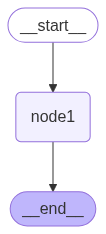

In [5]:
agent